In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations

pd.options.mode.chained_assignment = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PGA Data Analytics and Machine Learning/PGA 3.0 Content Creation/Advanced ML/RFM Analysis/online_retail_final.csv")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# RFM Analysis

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

**Recency**: How recently a customer has made a purchase

**Frequency**: How often a customer makes a purchase

**Monetary** Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.

*https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

![](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

*https://clevertap.com/blog/rfm-analysis/

**Let's perform RFM Analysis to our data.**

# Preparing RFM Table

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [ ]:
last_day = df.InvoiceDate.max() + dt.timedelta(days = 1)

In [ ]:
rfm_table = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                          "InvoiceNo": "nunique",
                                          "TotalPrice": "sum"})

rfm_table.rename(columns = {"InvoiceDate": "Recency",
                            "InvoiceNo": "Frequency",
                            "TotalPrice": "Monetary"}, inplace = True)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,4060.40
12348.0,75,4,1437.24
12349.0,19,1,1417.60
12350.0,310,1,294.40
12352.0,36,7,1385.74


In [ ]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12347.0,2,7,4060.40,5,5,5
12348.0,75,4,1437.24,2,4,4
12349.0,19,1,1417.60,4,1,4
12350.0,310,1,294.40,1,1,2
12352.0,36,7,1385.74,3,5,4


In [ ]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15
12348.0,75,4,1437.24,2,4,4,244,10
12349.0,19,1,1417.60,4,1,4,414,9
12350.0,310,1,294.40,1,1,2,112,4
12352.0,36,7,1385.74,3,5,4,354,12


# RFM Segments

**Champions**: Bought recently, buy often and spend the most

**Loyal customers**: Buy on a regular basis. Responsive to promotions.

**Potential loyalist**: Recent customers with average frequency.

**Recent customers**: Bought most recently, but not often.

**Promising**: Recent shoppers, but haven’t spent much.

**Needs attention**: Above average recency, frequency and monetary values. May not have bought very recently though.

**About to sleep**: Below average recency and frequency. Will lose them if not reactivated.

**At risk**: Some time since they’ve purchased. Need to bring them back!

**Can’t lose them**: Used to purchase frequently but haven’t returned for a long time.

**Hibernating**: Last purchase was long back and low number of orders. May be lost.

*https://futurice.com/blog/know-your-customers-with-rfm

I don't know is it original source of below segmentation map dict, but I take that code here.
https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [ ]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15,Champions
12348.0,75,4,1437.24,2,4,4,244,10,At-Risk
12349.0,19,1,1417.60,4,1,4,414,9,Promising
12350.0,310,1,294.40,1,1,2,112,4,Hibernating
12352.0,36,7,1385.74,3,5,4,354,12,Loyal Customers


# Visualizing RFM Grid

![](https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg)

*https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg

Well, I'm surprised noone plot the above graph.

I wrote these codes for visualizing above RFM grid.

In [ ]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

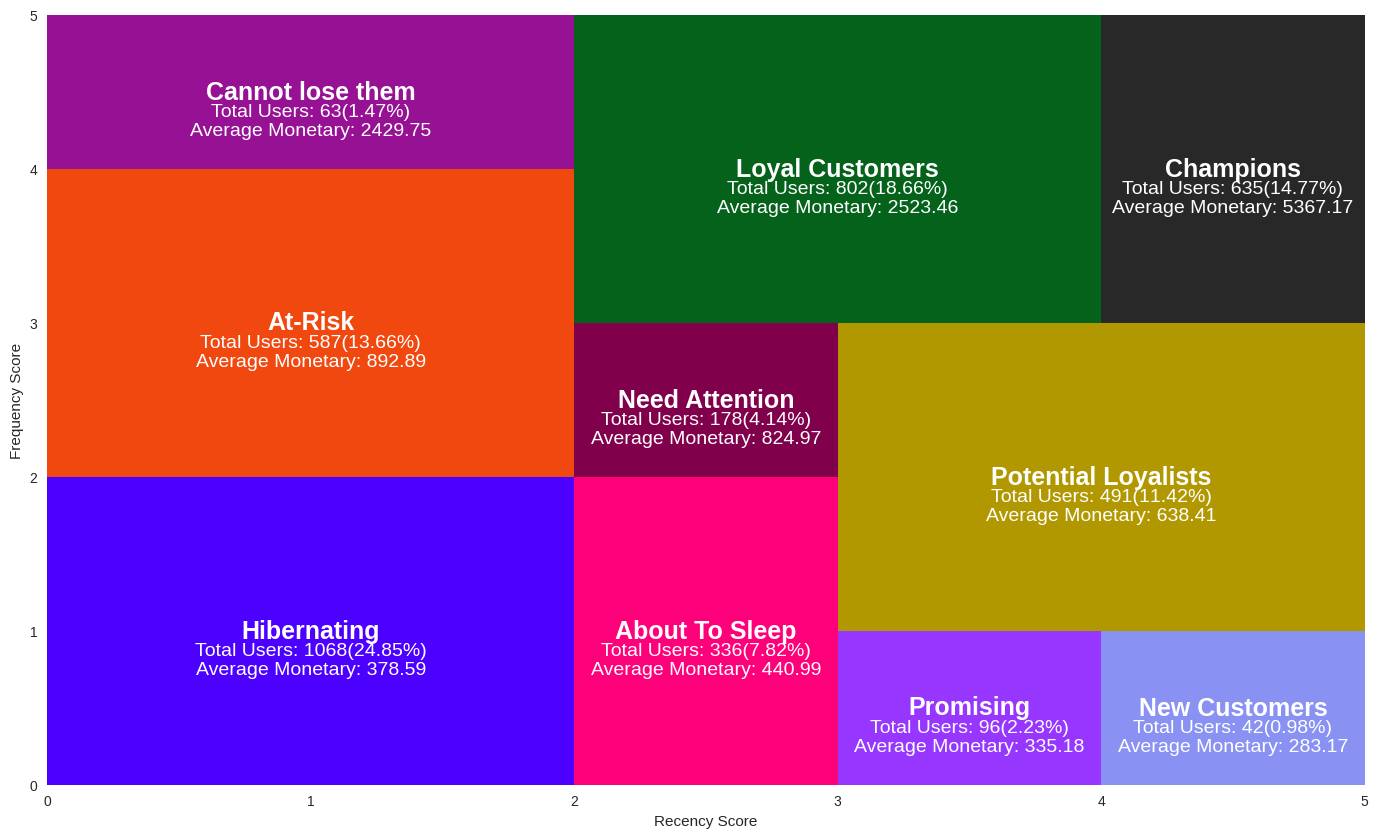

In [ ]:
fig, ax = plt.subplots(figsize = (17, 10))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF",
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):

    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]

    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)

    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()

    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))

    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2

    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")

    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")

sns.despine(left = True, bottom = True)
plt.show()

**Nice!**

# Visualizing RFM Segments

In [ ]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

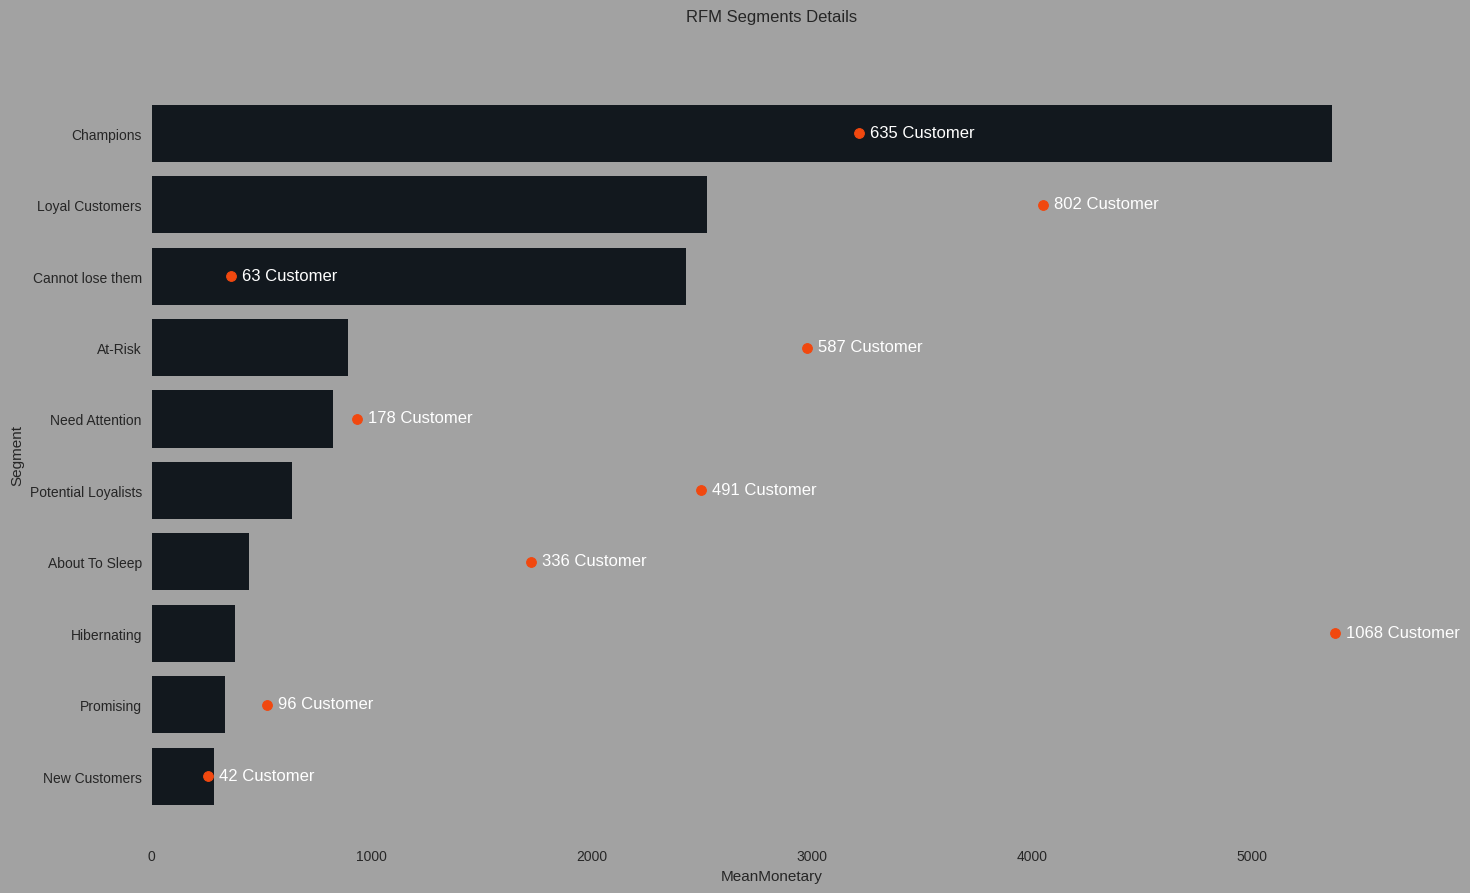

In [ ]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = False

fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanMonetary, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")

ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [ ]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

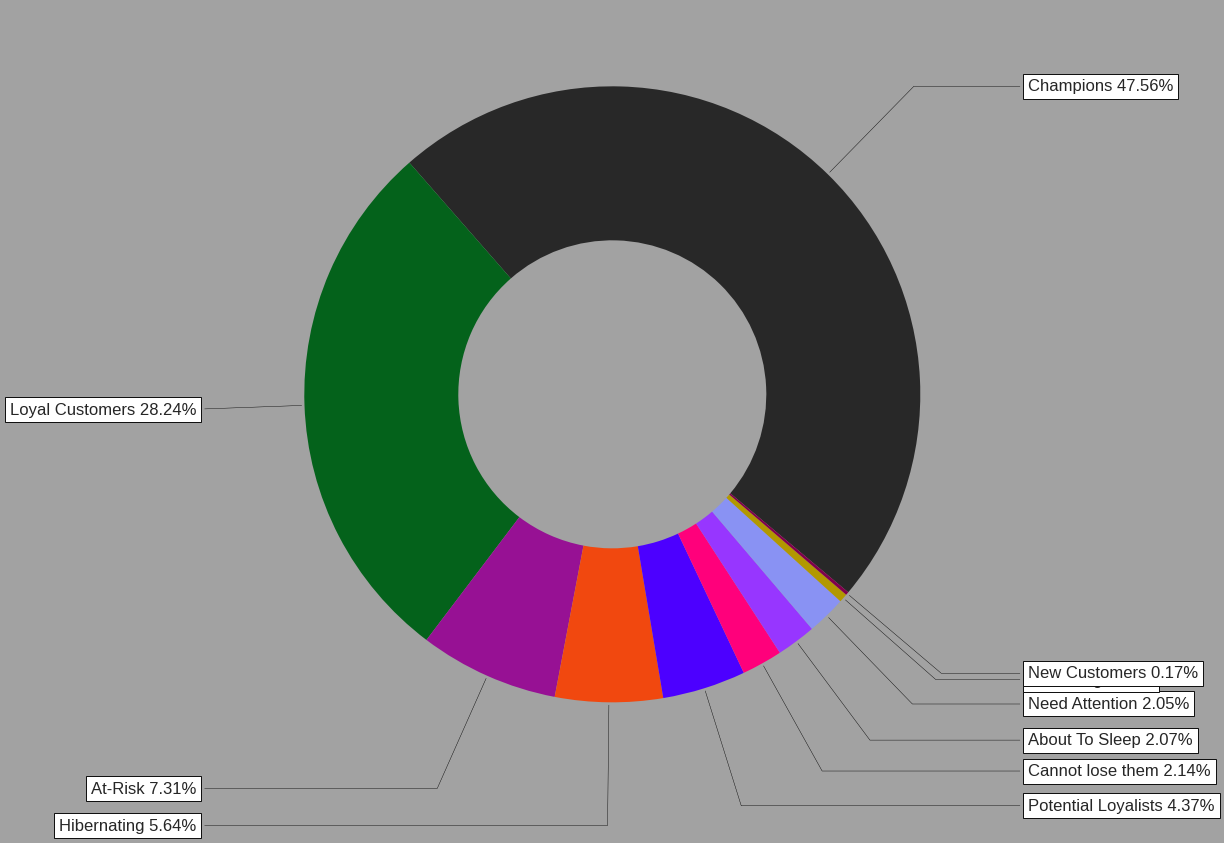

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), startangle=-40, normalize=False, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y),
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

47.5% of total revenue comes from "Champions" segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue.

In [ ]:
rfm = rfm_table2.groupby("Segment").agg({"CustomerID": "nunique",
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "Monetary": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

<ipython-input-21-ca5cc2a45984>:10: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  .set_precision(2)\


Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,336.00,587.00,63.00,635.00,1068.00,802.00,178.00,42.00,491.00,96.00
Recency,53.06,152.81,134.65,6.01,216.59,33.30,52.03,7.17,17.18,23.55
Frequency,1.14,2.85,8.30,12.04,1.09,6.39,2.30,1.00,1.99,1.00
Monetary,440.99,892.89,2429.75,5367.17,378.59,2523.46,824.97,283.17,638.41,335.18
